In [144]:
import numpy as np
import json
import random
import itertools
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
random.seed(1234)

# q5

In [143]:
with open("ENIGMA-51_annotations_master.json", "r", encoding="utf-8") as f:
    enigma_annotations = json.load(f)

scaling in `[0,1]`

In [145]:
original_width = 2272
original_height = 1278
target_width = 456
target_height = 256

# Calcolare i fattori di scala
scale_w = target_width / original_width
scale_h = target_height / original_height

for k, v in enigma_annotations['frame_annotations'].items():
    for i, obj in enumerate(v['objects']):
        # Ridimensiona le coordinate e le dimensioni
        obj['x'] = obj['x'] * scale_w
        obj['y'] = obj['y'] * scale_h
        obj['w'] = obj['w'] * scale_w
        obj['h'] = obj['h'] * scale_h
        
        # Normalizza i valori tra 0 e 1
        obj['x'] = obj['x'] / target_width
        obj['y'] = obj['y'] / target_height
        obj['w'] = obj['w'] / target_width
        obj['h'] = obj['h'] / target_height

In [146]:
enigma_annotations['frame_annotations']['102_10151']['objects']

[{'id': 345246,
  'x': 0.0,
  'y': 0.24334898278560252,
  'w': 0.05501760563380281,
  'h': 0.13928012519561817,
  'class_id': 3},
 {'id': 345247,
  'x': 0.11619718309859156,
  'y': 0.3270735524256651,
  'w': 0.02200704225352113,
  'h': 0.07668231611893583,
  'class_id': 4},
 {'id': 345248,
  'x': 0.0,
  'y': 0.47104851330203446,
  'w': 0.1307218309859155,
  'h': 0.3943661971830986,
  'class_id': 15},
 {'id': 345249,
  'x': 0.4595070422535211,
  'y': 0.2644757433489828,
  'w': 0.41241197183098594,
  'h': 0.5195618153364633,
  'class_id': 14},
 {'id': 345251,
  'x': 0.22711267605633803,
  'y': 0.0,
  'w': 0.2808098591549296,
  'h': 0.05086071987480438,
  'class_id': 2}]

In [147]:
train_vid = []
val_vid = []
test_vid = []

for k, v in enigma_annotations['videos'].items():
    split_type = v.get("split", "").lower()
    if split_type == "train":
        train_vid.append(int(k))
    elif split_type in ["val", "valid", "validation"]:
        val_vid.append(int(k))
    elif split_type == "test":
        test_vid.append(int(k))

len(train_vid), len(val_vid), len(test_vid)

(27, 8, 16)

In [148]:
video_frame_count = {}
for k, v in enigma_annotations['videos'].items():
    video_frame_count[int(k)] = int(v['frame_count'])

In [149]:
splitted_enigma = {
    k: v
    for k, v in enigma_annotations['frame_annotations'].items()
    # if v['video_id'] in train_vid
    # if v['video_id'] in val_vid
    if v['video_id'] in test_vid
}


prendo le annotazioni in ho almeno 2 hoi di oggetti diversi (`class_id` diverse)

In [150]:
AREA_TRESHOLD = 0.0004

enigma_at_least_2_hoi = {}

for k, v in splitted_enigma.items():
    interactions = []
    for inter in v.get("interactions", []):
        id = inter['id_obj']
        obj = [obj for obj in v.get("objects", []) if obj['id'] == id][0]
        
        if obj['w'] * obj['h'] > AREA_TRESHOLD:
            interactions.append(inter)
        

    if len(interactions) < 2:
        continue
    
    # Mappa id_obj -> class_id
    obj_classes = {obj['id']: obj['class_id'] for obj in v.get("objects", [])}
    
    # Tieni solo la prima interazione per ciascun class_id
    seen_classes = set()
    filtered_interactions = []
    for inter in interactions:
        obj_id = inter.get("id_obj")
        class_id = obj_classes.get(obj_id)
        if class_id is not None and class_id not in seen_classes:
            filtered_interactions.append(inter)
            seen_classes.add(class_id)

    if len(seen_classes) >= 2:
        enigma_at_least_2_hoi[k] = {
            "video_id": v['video_id'],
            "frame_id": v["filename"].split("_")[1].split(".jpg")[0],
            "interactions": filtered_interactions,
            "objects": v.get("objects", [])
        }

nel benchmark vengono richieste 3 versioni per ogni immagine

creo un dizionario:
```python
'<class_id>': {
    'name': <class_name>
    'values': [
        {
            'value': [<frame_id>,[<x0>,<y0>,<x1>,<y1>]],
            'frame_id': <frame_id>,
            'video_id': <video_id>,
            'object_id': <object_id>
        },
        ...
    ]   
}
```

In [151]:
def bbox_iou(boxA, boxB):
    """
    Calcola l'Intersection over Union (IoU) tra due bbox
    box formato [x0, y0, x1, y1]
    """
    # coordinate dell'intersezione
    x_left = max(boxA[0], boxB[0])
    y_top = max(boxA[1], boxB[1])
    x_right = min(boxA[2], boxB[2])
    y_bottom = min(boxA[3], boxB[3])

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0  # nessuna sovrapposizione

    # area intersezione
    inter_area = (x_right - x_left) * (y_bottom - y_top)

    # area totale dei due box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IoU
    iou = inter_area / float(boxA_area + boxB_area - inter_area)
    return iou

OVERLAP_TRESHOLD = 0.3  # massimo overlap accettato (30%)

def is_below_overlap_threshold(new_box, objs, threshold=OVERLAP_TRESHOLD):
    """
    Restituisce True se il nuovo box NON supera la soglia di overlap con nessun oggetto
    """
    for other in objs:
        if other["id"] == obj.get("id"):  # protezione se obj non esiste
            continue
        
        ox0, oy0 = other["x"], other["y"]
        ox1, oy1 = ox0 + other["w"], oy0 + other["h"]
        other_box = [ox0, oy0, ox1, oy1]

        if bbox_iou(new_box, other_box) > threshold:
            return False  # ha troppo overlap con almeno un altro oggetto
    
    return True  # nessun overlap supera la soglia

creo dizionario oggetti per avere le altre versioni dell'oggetto.

filtro tenendo gli oggetti che non hanno molto overlap con gli altri (si vedono bene)

In [152]:
enigma_objects = {}

for class_id, class_info in enigma_annotations["object_classes"].items():
    class_id = int(class_id)
    class_name = class_info["class_name"]

    enigma_objects[class_id] = {
        "name": class_name,
        "values": []
    }

    for k, v in enigma_annotations["frame_annotations"].items():
        objs = v.get("objects", [])
        hands = v.get("hands", [])
        frame = v["filename"].split("_")[1].split(".jpg")[0]

        for obj in objs:
            if obj["class_id"] == class_id:
                # skippo obj troppo piccoli
                box_area = obj["w"] * obj["h"]
                if(box_area < AREA_TRESHOLD):
                    continue

                x0 = obj["x"]
                y0 = obj["y"]
                x1 = x0 + obj["w"]
                y1 = y0 + obj["h"]
                new_box = [x0, y0, x1, y1]
                
                # calcolo l’IoU con tutti gli altri
                if is_below_overlap_threshold(new_box, objs) and is_below_overlap_threshold(new_box, hands):
                    enigma_objects[class_id]["values"].append({
                        "value": [int(frame), new_box],
                        "frame_id": frame,
                        "video_id": v['video_id'],
                        "object_id": obj["id"],
                    })

In [153]:
enigma_objects[0]

{'name': 'power_supply',
 'values': [{'value': [3633,
    [0.00528169014084507,
     0.40688575899843504,
     0.3102992957746479,
     0.9890453834115805]],
   'frame_id': '3633',
   'video_id': 44,
   'object_id': 236},
  {'value': [3853,
    [0.4236641725352113,
     0.06106885758998436,
     0.6226144366197184,
     0.6641220657276996]],
   'frame_id': '3853',
   'video_id': 44,
   'object_id': 240},
  {'value': [4142,
    [0.4408397887323943,
     0.12977073552425666,
     0.6397900528169014,
     0.7302801251956182]],
   'frame_id': '4142',
   'video_id': 44,
   'object_id': 243},
  {'value': [4805,
    [0.22095070422535212,
     0.5892018779342724,
     0.40492957746478875,
     0.9976525821596245]],
   'frame_id': '4805',
   'video_id': 44,
   'object_id': 248},
  {'value': [4867,
    [0.20554577464788734,
     0.5696400625978091,
     0.400968309859155,
     0.9960876369327074]],
   'frame_id': '4867',
   'video_id': 44,
   'object_id': 251},
  {'value': [5049,
    [0.43082042

In [154]:
[x['value'] for x in enigma_objects[17]['values']]

[[898,
  [0.4071302816901408,
   0.5727699530516432,
   0.4493838028169014,
   0.6494522691705791]],
 [927, [0.4375, 0.5453834115805947, 0.48151408450704225, 0.6181533646322379]],
 [938,
  [0.4330985915492958,
   0.5172143974960877,
   0.47623239436619724,
   0.5884194053208138]],
 [953,
  [0.42913732394366194,
   0.528169014084507,
   0.46786971830985913,
   0.6064162754303599]],
 [953,
  [0.545774647887324,
   0.5015649452269171,
   0.5871478873239437,
   0.5774647887323944]],
 [37529,
  [0.4723283450704226,
   0.5012723004694836,
   0.5209925176056338,
   0.5903309859154929]],
 [37551,
  [0.46946566901408454,
   0.49363849765258216,
   0.5195611795774648,
   0.5776079812206573]],
 [37565,
  [0.39832746478873243,
   0.5039123630672927,
   0.44498239436619724,
   0.5845070422535212]],
 [37576,
  [0.37191901408450706,
   0.4827856025039124,
   0.4119718309859155,
   0.5704225352112676]],
 [842,
  [0.4546654929577465,
   0.8294209702660407,
   0.49471830985915494,
   0.8982785602503912]

In [53]:
enigma_at_least_2_hoi['46_1814']['objects']

[{'id': 2077,
  'x': 1671.481,
  'y': 728.427,
  'w': 29.267,
  'h': 97.558,
  'class_id': 10},
 {'id': 2078, 'x': 984, 'y': 328, 'w': 310, 'h': 228, 'class_id': 24},
 {'id': 2079, 'x': 544, 'y': 422, 'w': 331, 'h': 255, 'class_id': 23},
 {'id': 2080, 'x': 149, 'y': 447, 'w': 541, 'h': 629, 'class_id': 5},
 {'id': 2081, 'x': 1021, 'y': 374, 'w': 386, 'h': 577, 'class_id': 6},
 {'id': 2082, 'x': 1188, 'y': 611, 'w': 289, 'h': 109, 'class_id': 7},
 {'id': 2083, 'x': 1492, 'y': 750, 'w': 234, 'h': 289, 'class_id': 9}]

In [55]:
ONE_SECOND = 30  # 30 fps
MINIMAL_TEMPORAL_GAP = ONE_SECOND * 30 

def get_obj_versions(enigma_objects, v, temporal_gap=MINIMAL_TEMPORAL_GAP, min_gap=10):
    # 1. prendi tutti tranne v
    candidates = [
        val for val in enigma_objects["values"]
        if val["frame_id"] != v.get("frame_id") and val["video_id"] == v.get("video_id")
    ]

    # 2. cerchiamo una combinazione di 3 che rispettino il vincolo
    for comb in itertools.combinations(candidates, 3):
        fids = [int(c["frame_id"]) for c in comb]
        # controlla che la distanza minima tra i frame_id sia > temporal_gap
        if all(abs(a - b) > temporal_gap for i, a in enumerate(fids) for j, b in enumerate(fids) if i < j):
            return list(comb)
    
    # 3. se non si trova una valida si dimezza il tempo
    if temporal_gap > min_gap:
        return get_obj_versions(enigma_objects, v, temporal_gap // 2, min_gap)
    else:
        return candidates

In [56]:
def process_enigma_item(idx, v):
    result = {
        "id": f"Q5_{int(idx):06d}",
        "video_id": str(v["video_id"]),
        "question": "What did I use with [VQ]?",
        "question_image": {},
        "answers": {},
        "correct": None
    }

    # --- QUESTION IMAGE ---
    question_obj_id = v["interactions"][0]["id_obj"]
    question_obj_category = next(obj["class_id"] for obj in v["objects"] if obj["id"] == question_obj_id)
    question_obj_name = enigma_objects[question_obj_category]["name"]
    question_obj = get_obj_versions(enigma_objects[question_obj_category], v)
    result["question_image"] = {question_obj_name: [val["value"] for val in question_obj]}

    # --- CORRECT ANSWER ---
    correct_answer_obj_id = v["interactions"][1]["id_obj"]
    correct_answer_obj_category = next(obj["class_id"] for obj in v["objects"] if obj["id"] == correct_answer_obj_id)
    correct_answer_obj_name = enigma_objects[correct_answer_obj_category]["name"]
    correct_answer_obj = get_obj_versions(enigma_objects[correct_answer_obj_category], v)
    correct_answer_idx = random.randint(1, 5)

    # --- WRONG ANSWERS ---
    wrong_objs = [obj for obj in v['objects'] if obj['id'] != correct_answer_obj_id and obj['class_id'] not in [question_obj_category, correct_answer_obj_category]][:4]
    wrong_answer_candidates = []

    for obj in wrong_objs:
        wrong_obj_category = obj['class_id']
        if wrong_obj_category in [cat['cid'] for cat in wrong_answer_candidates]:
            continue
        
        wrong_obj = get_obj_versions(enigma_objects[wrong_obj_category], v)
        
        if not wrong_obj:
            continue
        
        wrong_answer_candidates.append({"cid": wrong_obj_category, "values": wrong_obj})

    used_categories = {obj['class_id'] for obj in wrong_objs}
    all_categories = [
        category_id for category_id in enigma_objects.keys()
        if category_id not in [question_obj_category, correct_answer_obj_category, *used_categories]
    ]
    while len(wrong_answer_candidates) < 4:
        random_category = random.choice(all_categories)
        if random_category in [cat['cid'] for cat in wrong_answer_candidates]:
            continue
        # MAX_VIDEO_LEN = video_frame_count[v['video_id']]
        vals = [val for val in enigma_objects[random_category]["values"] if (val['video_id']==v['video_id'] and int(val['frame_id']) != int(v['frame_id']))]
        candidate = random.sample(vals, min(3, len(vals)))
        if all(candidate != c["values"] for c in wrong_answer_candidates):
            wrong_answer_candidates.append({"cid": random_category, "values": candidate})

    # --- POPOLA LE RISPOSTE ---
    answers = {}
    wrong_idx = 0
    for i in range(1,6):
        if i == correct_answer_idx:
            answers[str(i)] = {correct_answer_obj_name: [val["value"] for val in correct_answer_obj]}
        else:
            wrong_choice = wrong_answer_candidates[wrong_idx]
            wrong_name = enigma_objects[wrong_choice["cid"]]["name"]
            answers[str(i)] = {wrong_name: [val["value"] for val in wrong_choice["values"]]}
            wrong_idx += 1

    result["answers"] = answers
    result["correct"] = correct_answer_idx

    return str(idx), result

In [ ]:
enigma_q5 = {
    "id": {},
    "video_id": {},
    "question": {},
    "question_image": {},
    "answers": {},
    "correct": {}
}

with ThreadPoolExecutor(max_workers=20) as executor:  # o più thread in base al tuo CPU
    futures = [executor.submit(process_enigma_item, idx, v) for idx, (k, v) in enumerate(enigma_at_least_2_hoi.items())]
    for f in tqdm(as_completed(futures), total=len(futures)):
        idx, res = f.result()
        for key in enigma_q5.keys():
            enigma_q5[key][idx] = res[key]

In [134]:
# JSON_SPLIT = "TRAIN"
# JSON_SPLIT = "VALIDATION"
JSON_SPLIT = "TEST"

with open(f"AMEGO/AMB/Q5_ENIGMA_{JSON_SPLIT}.json", "w", encoding="utf-8") as f:
    json.dump(enigma_q5, f, ensure_ascii=False, indent=2)

## visual

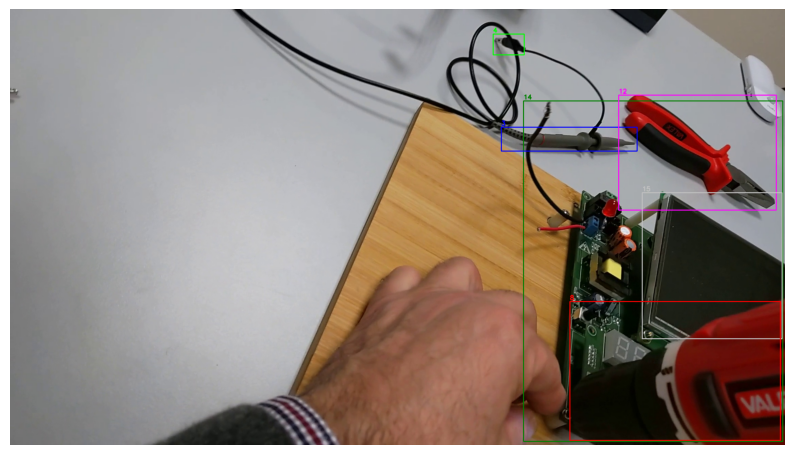

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Percorso dell'immagine
img_path = "46_6043.jpg"

# Lista di oggetti
# x = div_arr[1]['value']['objects']
x = [{'id': 2560,
  'x': 1505.634,
  'y': 269.908,
  'w': 760.946,
  'h': 998.336,
  'class_id': 14},
 {'id': 2562, 'x': 1416, 'y': 73, 'w': 91, 'h': 61, 'class_id': 4},
 {'id': 2563, 'x': 1440, 'y': 346, 'w': 398, 'h': 70, 'class_id': 3},
 {'id': 2564, 'x': 1784, 'y': 252, 'w': 462, 'h': 337, 'class_id': 12},
 {'id': 2565, 'x': 1853, 'y': 538, 'w': 410, 'h': 428, 'class_id': 15},
 {'id': 2566, 'x': 1641, 'y': 857, 'w': 617, 'h': 407, 'class_id': 8}]

# Apri immagine
img = cv2.imread(img_path)


# Colori diversi per class_id (opzionale)
colors = {
    0: (128, 128, 128),    # power_supply: grigio
    1: (139, 69, 19),      # power_supply_cables: marrone
    2: (0, 128, 128),      # oscilloscope: teal
    3: (255, 0, 0),        # oscilloscope_probe_tip: rosso
    4: (0, 255, 0),        # oscilloscope_ground_clip: verde
    5: (255, 165, 0),      # welder_station: arancione
    6: (128, 0, 128),      # welder_base: viola
    7: (255, 20, 147),     # welder_probe_tip: rosa
    8: (0, 0, 255),        # electric_screwdriver: blu
    9: (0, 191, 255),      # electric_screwdriver_battery: celeste
    10: (255, 255, 255),   # battery_connector: bianco
    11: (255, 255, 0),     # screwdriver: giallo
    12: (255, 0, 255),     # pliers: magenta
    13: (0, 255, 255),     # high_voltage_board: ciano
    14: (0, 128, 0),       # low_voltage_board: verde scuro
    15: (192, 192, 192),   # low_voltage_board_screen: argento
    16: (128, 0, 0),       # register: marrone scuro
    17: (255, 69, 0),      # left_red_button: rosso arancio
    18: (0, 255, 127),     # left_green_button: verde primavera
    19: (178, 34, 34),     # right_red_button: rosso mattone
    20: (50, 205, 50),     # right_green_button: verde lime
    21: (210, 105, 30),    # socket_1: cioccolato
    22: (205, 133, 63),    # socket_2: sabbia
    23: (139, 0, 139),     # socket_3: viola scuro
    24: (75, 0, 130)       # socket_4: indaco
}

# Disegna i bounding box
for obj in x:
    x1, y1 = int(obj['x']), int(obj['y'])
    x2, y2 = x1 + int(obj['w']), y1 + int(obj['h'])
    class_id = obj['class_id']
    color = colors.get(class_id, (255, 255, 255))  # bianco se classe non mappata
    
    # Disegna rettangolo
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    
    # Etichetta classe sopra il box
    cv2.putText(img, str(class_id), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Converti BGR in RGB per Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostra immagine con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


# stats

In [112]:
# with open(f"ENIGMA_AMB/Q5_ENIGMA_TRAIN.json", "r", encoding="utf-8") as f:
#     enigma_q5_TRAIN = json.load(f)
# with open(f"ENIGMA_AMB/Q5_ENIGMA_VALIDATION.json", "r", encoding="utf-8") as f:
#     enigma_q5_VALIDATION = json.load(f)
with open(f"Q5_ENIGMA_TEST.json", "r", encoding="utf-8") as f:
    enigma_q5_TEST = json.load(f)

numero di domande per ogni video

In [113]:
counts = [
    # Counter(enigma_q5_TRAIN['video_id'].values()),
    # Counter(enigma_q5_VALIDATION['video_id'].values()),
    Counter(enigma_q5_TEST['video_id'].values())
]
counts

[Counter({'65': 88,
          '95': 78,
          '66': 75,
          '86': 54,
          '143': 44,
          '89': 43,
          '53': 40,
          '141': 36,
          '47': 35,
          '49': 24,
          '46': 22,
          '85': 22,
          '144': 22,
          '88': 15,
          '107': 12,
          '131': 5})]

In [115]:
sorted(counts[0].items(), key=lambda x: int(x[0]))

[('46', 22),
 ('47', 35),
 ('49', 24),
 ('53', 40),
 ('65', 88),
 ('66', 75),
 ('85', 22),
 ('86', 54),
 ('88', 15),
 ('89', 43),
 ('95', 78),
 ('107', 12),
 ('131', 5),
 ('141', 36),
 ('143', 44),
 ('144', 22)]

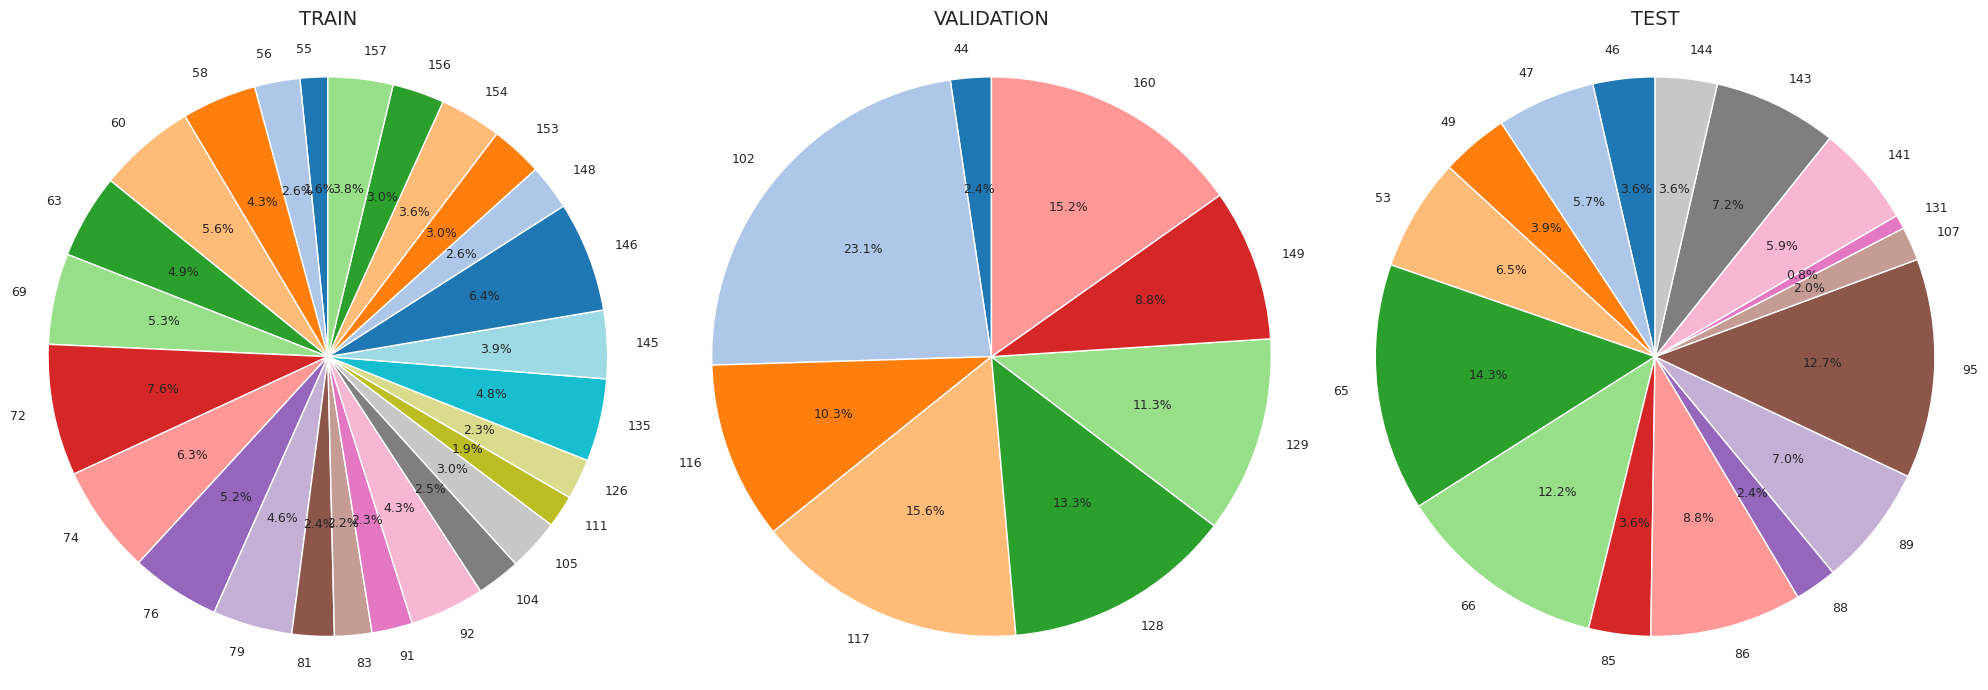

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

titles = ["TRAIN", "VALIDATION", "TEST"]

# Impostiamo una palette Seaborn
palette = sns.color_palette("tab20")

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for ax, counter, title in zip(axes, counts, titles):
    labels = list(counter.keys())
    sizes = list(counter.values())
    
    # Se ci sono più categorie dei colori disponibili, Seaborn ripete i colori
    colors = palette[:len(labels)]
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
           colors=colors, textprops={'fontsize': 9})
    ax.set_title(title, fontsize=14)
    ax.axis('equal')

sns.set_style("whitegrid")
plt.tight_layout()
plt.show()

chord diagram (categoria_VQ, categoria_RISPOSTA-CORRETTA)

In [37]:
corrects = []
for k, v in enigma_q5_TEST['correct'].items():
    corrects.append(v)
# corrects

In [38]:
pairs = []

# corrects = [...]  # lista di indici corretti, già definita

for idx, (k, v) in enumerate(enigma_q5_TEST['question_image'].items()):
    # prendo il primo (e unico) nome dalla question_image
    q_name = list(v.keys())[0]

    # prendo l'elemento corretto dagli answers
    correct_idx = str(corrects[idx])   # converto in stringa perché le chiavi sono stringhe
    ans_dict = enigma_q5_TEST['answers'][k][correct_idx]
    a_name = list(ans_dict.keys())[0]

    # salvo la coppia
    pairs.append((q_name, a_name))

print(pairs)

[('low_voltage_board', 'oscilloscope_probe_tip'), ('low_voltage_board', 'power_supply_cables'), ('low_voltage_board', 'electric_screwdriver'), ('oscilloscope_ground_clip', 'oscilloscope_probe_tip'), ('battery_connector', 'electric_screwdriver_battery'), ('low_voltage_board', 'power_supply_cables'), ('low_voltage_board', 'electric_screwdriver'), ('low_voltage_board', 'oscilloscope_probe_tip'), ('oscilloscope_ground_clip', 'oscilloscope_probe_tip'), ('low_voltage_board', 'power_supply_cables'), ('low_voltage_board', 'low_voltage_board_screen'), ('low_voltage_board_screen', 'low_voltage_board'), ('oscilloscope_ground_clip', 'oscilloscope_probe_tip'), ('power_supply_cables', 'oscilloscope_probe_tip'), ('power_supply_cables', 'oscilloscope_probe_tip'), ('power_supply_cables', 'oscilloscope_probe_tip'), ('low_voltage_board', 'oscilloscope_probe_tip'), ('oscilloscope_ground_clip', 'oscilloscope_probe_tip'), ('power_supply_cables', 'oscilloscope_probe_tip'), ('low_voltage_board', 'power_supply

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
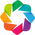

:Chord   [start,end]

In [39]:
import holoviews as hv
hv.extension('bokeh')

# Holoviews Chord accetta (source, target) come edges
chord = hv.Chord(pairs)
chord.opts(
    labels='index',
    cmap='Category20',
    edge_color='source',
    node_color='index',
    width=600,
    height=600
)

istogrammi categorie in amb

/tmp/ipykernel_16761/2667985465.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(all_categories, rotation=45, ha='right')
/tmp/ipykernel_16761/2667985465.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(all_categories, rotation=45, ha='right')


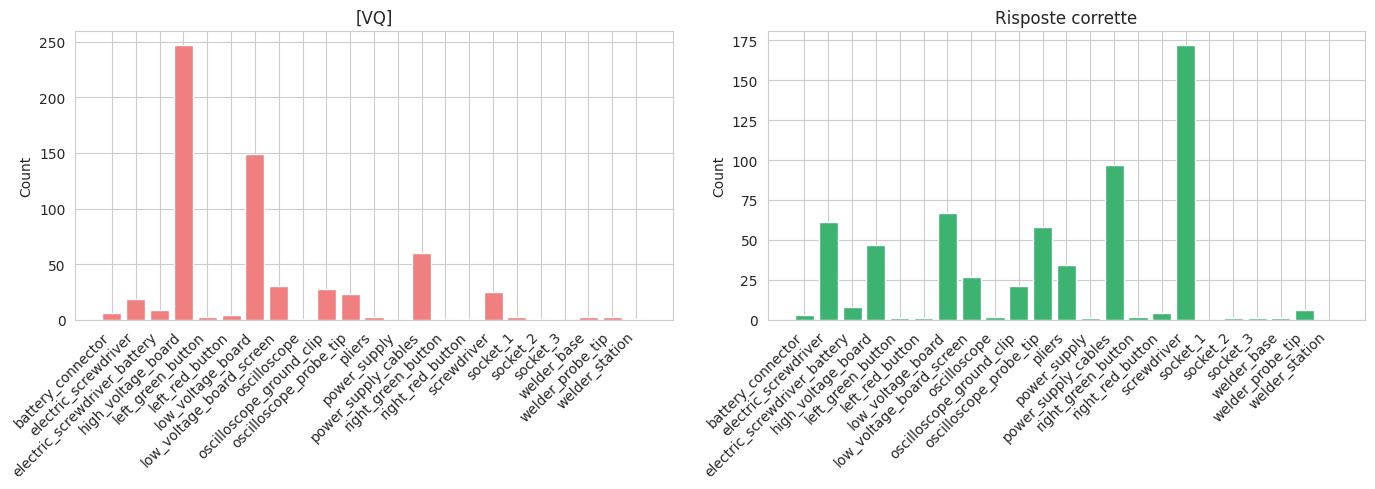

In [42]:
from collections import Counter
import matplotlib.pyplot as plt

# Conta le occorrenze
first_counts = Counter([p[0] for p in pairs])
second_counts = Counter([p[1] for p in pairs])

# Definisci l'ordine comune delle categorie
all_categories = sorted(set(first_counts.keys()) | set(second_counts.keys()))

# Estrai i valori secondo l'ordine comune
first_values = [first_counts.get(cat, 0) for cat in all_categories]
second_values = [second_counts.get(cat, 0) for cat in all_categories]

# Crea la figura con 2 subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma prima posizione
axes[0].bar(all_categories, first_values, color='lightcoral')
axes[0].set_xticklabels(all_categories, rotation=45, ha='right')
axes[0].set_ylabel('Count')
axes[0].set_title('[VQ]')

# Istogramma seconda posizione
axes[1].bar(all_categories, second_values, color='mediumseagreen')
axes[1].set_xticklabels(all_categories, rotation=45, ha='right')
axes[1].set_ylabel('Count')
axes[1].set_title('Risposte corrette')

plt.tight_layout()
plt.show()

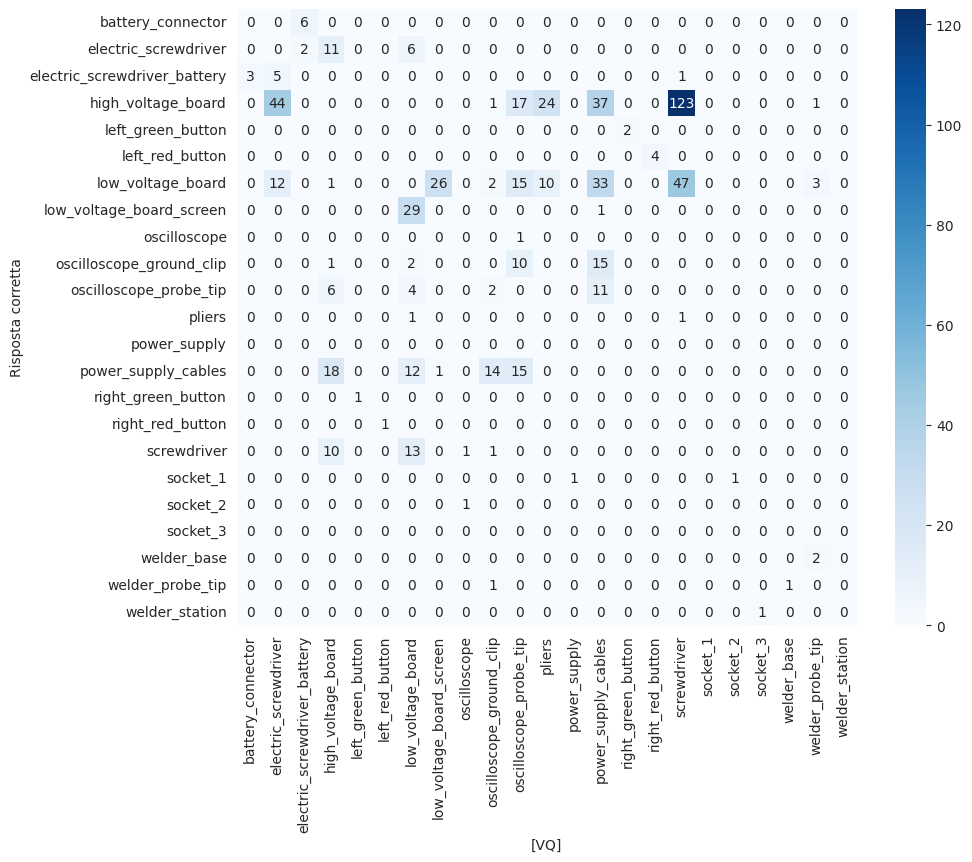

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# dataframe
df = pd.DataFrame(pairs, columns=['obj1', 'obj2'])

# matrice di co-occorrenza
co_matrix = df.groupby(['obj1', 'obj2']).size().unstack(fill_value=0)

# definisci ordine fisso: unisci tutte le categorie presenti in obj1 e obj2
categories = sorted(set(df['obj1']).union(set(df['obj2'])))

# riordina righe e colonne secondo categories
co_matrix = co_matrix.reindex(index=categories, columns=categories, fill_value=0)

# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("[VQ]")
plt.ylabel("Risposta corretta")
plt.show()


## bench

In [387]:
with open(f"Q5_ENIGMA_TEST.json", "r", encoding="utf-8") as f:
    enigma_q5_TEST = json.load(f)
with open(f"RESULTS.json", "r", encoding="utf-8") as f:
    res = json.load(f)

In [127]:
val = [x['response'] for x in res]
len(val)

108

percentuale di risposte corrette per ogni domanda

In [388]:
res[0]

{'dataset_type': 'V3',
 'results': '118/615',
 'percentuale': '19.19%',
 'response': {'Q5_000108': ['5', 5],
  'Q5_000091': ['1', 2],
  'Q5_000074': ['3', 4],
  'Q5_000141': ['4', 2],
  'Q5_000124': ['1', 5],
  'Q5_000107': ['1', 4],
  'Q5_000090': ['5', 3],
  'Q5_000073': ['4', 4],
  'Q5_000038': ['4', 1],
  'Q5_000123': ['2', 4],
  'Q5_000106': ['5', 4],
  'Q5_000002': ['5', 1],
  'Q5_000089': ['5', 4],
  'Q5_000072': ['5', 3],
  'Q5_000139': ['4', 1],
  'Q5_000122': ['5', 4],
  'Q5_000105': ['5', 1],
  'Q5_000088': ['2', 3],
  'Q5_000071': ['3', 1],
  'Q5_000138': ['4', 4],
  'Q5_000121': ['2', 5],
  'Q5_000104': ['5', 4],
  'Q5_000087': ['2', 5],
  'Q5_000070': ['4', 2],
  'Q5_000120': ['5', 4],
  'Q5_000103': ['4', 2],
  'Q5_000086': ['4', 3],
  'Q5_000069': ['5', 1],
  'Q5_000102': ['4', 5],
  'Q5_000085': ['2', 1],
  'Q5_000068': ['1', 4],
  'Q5_000023': ['2', 3],
  'Q5_000118': ['4', 5],
  'Q5_000000': ['1', 4],
  'Q5_000101': ['1', 2],
  'Q5_000084': ['4', 3],
  'Q5_000004': [

In [152]:
enigma_q5_TEST['id']

{'108': 'Q5_000108',
 '91': 'Q5_000091',
 '74': 'Q5_000074',
 '141': 'Q5_000141',
 '124': 'Q5_000124',
 '107': 'Q5_000107',
 '90': 'Q5_000090',
 '73': 'Q5_000073',
 '38': 'Q5_000038',
 '123': 'Q5_000123',
 '106': 'Q5_000106',
 '2': 'Q5_000002',
 '89': 'Q5_000089',
 '72': 'Q5_000072',
 '139': 'Q5_000139',
 '122': 'Q5_000122',
 '105': 'Q5_000105',
 '88': 'Q5_000088',
 '71': 'Q5_000071',
 '138': 'Q5_000138',
 '121': 'Q5_000121',
 '104': 'Q5_000104',
 '87': 'Q5_000087',
 '70': 'Q5_000070',
 '120': 'Q5_000120',
 '103': 'Q5_000103',
 '86': 'Q5_000086',
 '69': 'Q5_000069',
 '102': 'Q5_000102',
 '85': 'Q5_000085',
 '68': 'Q5_000068',
 '23': 'Q5_000023',
 '118': 'Q5_000118',
 '0': 'Q5_000000',
 '101': 'Q5_000101',
 '84': 'Q5_000084',
 '4': 'Q5_000004',
 '67': 'Q5_000067',
 '5': 'Q5_000005',
 '40': 'Q5_000040',
 '117': 'Q5_000117',
 '100': 'Q5_000100',
 '83': 'Q5_000083',
 '66': 'Q5_000066',
 '39': 'Q5_000039',
 '116': 'Q5_000116',
 '99': 'Q5_000099',
 '1': 'Q5_000001',
 '82': 'Q5_000082',
 '65'

In [389]:
video_ids = {f'{k}': {
    'total': 0,
    'correct': 0,
    'accuracy': 0
} for k in test_vid}
for r in res:
    ans = r["response"]  # questo è il dict grande che hai mostrato
    for k,v in ans.items():
        q_id = [x for x,xx in enigma_q5_TEST['id'].items() if xx == k][0]
        id = [xx for x,xx in enigma_q5_TEST['video_id'].items() if x == q_id][0]
        video_ids[id]['total']+=1
        if(v[0] == str(v[1])):
            video_ids[id]['correct']+=1
            video_ids[id]['accuracy'] = int(video_ids[id]['correct']) / int(video_ids[id]['total'])

In [234]:
len(res)

108

In [390]:
for k,v in video_ids.items():
    print(k,v['accuracy']*100)

46 18.239258635214828
47 27.361735908970626
49 35.766705291618386
53 10.87410155344308
65 26.863157894736844
66 9.198666502037288
85 37.37373737373738
86 26.565985927578513
88 24.320987654320987
89 33.90049536937325
95 21.607503264869997
107 15.467904098994586
131 35.25046382189239
141 18.21465428276574
143 7.711864406779662
144 30.81787521079258


In [251]:
acc=[]
for k,v in video_ids.items():
    acc.append(v['accuracy'])
np.mean(acc)*100

np.float64(23.72094357482038)

In [412]:
question_ids = {f'{v}': {
    'correct_idx': 0,
    'given': [],
} for k,v in enigma_q5_TEST['id'].items()}
for r in res:
    ans = r["response"]  # questo è il dict grande che hai mostrato
    for k,v in ans.items():
        question_ids[k]['correct_idx']=v[1]
        question_ids[k]['given'].append(v[0])

In [414]:
accs=[]
for key, value in question_ids.items():
    correct = str(value['correct_idx'])  # converto in stringa per confronto coerente
    given = [str(x) for x in value['given']]  # converto tutti in stringa
    total = len(given)
    if total > 0:
        correct_count = sum(1 for x in given if x == correct)
        accuracy = correct_count / total
    else:
        accuracy = None  # o 0, se vuoi considerare assenza di risposte come 0%
    accs.append(accuracy)
    print(f"{key}: {correct_count}/{total} correct, accuracy = {accuracy*100:.2f}")


Q5_000108: 58/108 correct, accuracy = 53.70
Q5_000091: 40/108 correct, accuracy = 37.04
Q5_000074: 39/108 correct, accuracy = 36.11
Q5_000141: 0/108 correct, accuracy = 0.00
Q5_000124: 37/108 correct, accuracy = 34.26
Q5_000107: 60/108 correct, accuracy = 55.56
Q5_000090: 0/108 correct, accuracy = 0.00
Q5_000073: 108/108 correct, accuracy = 100.00
Q5_000038: 21/108 correct, accuracy = 19.44
Q5_000123: 37/108 correct, accuracy = 34.26
Q5_000106: 0/108 correct, accuracy = 0.00
Q5_000002: 22/108 correct, accuracy = 20.37
Q5_000089: 0/108 correct, accuracy = 0.00
Q5_000072: 58/108 correct, accuracy = 53.70
Q5_000139: 34/108 correct, accuracy = 31.48
Q5_000122: 0/108 correct, accuracy = 0.00
Q5_000105: 20/108 correct, accuracy = 18.52
Q5_000088: 0/108 correct, accuracy = 0.00
Q5_000071: 54/108 correct, accuracy = 50.00
Q5_000138: 56/108 correct, accuracy = 51.85
Q5_000121: 26/108 correct, accuracy = 24.07
Q5_000104: 0/108 correct, accuracy = 0.00
Q5_000087: 0/108 correct, accuracy = 0.00
Q5

In [384]:
question_ids

{}

In [415]:
zero_acc=[]
for key, value in question_ids.items():
    # Converto tutto in stringhe per confronto coerente
    correct = str(value['correct_idx'])
    given = [str(x) for x in value['given']]
    
    # Controllo se correct non è in given
    if correct not in given:
        zero_acc.append(key)
zero_acc

['Q5_000141',
 'Q5_000090',
 'Q5_000106',
 'Q5_000089',
 'Q5_000122',
 'Q5_000088',
 'Q5_000104',
 'Q5_000087',
 'Q5_000086',
 'Q5_000102',
 'Q5_000085',
 'Q5_000068',
 'Q5_000118',
 'Q5_000101',
 'Q5_000084',
 'Q5_000117',
 'Q5_000100',
 'Q5_000083',
 'Q5_000116',
 'Q5_000099',
 'Q5_000001',
 'Q5_000082',
 'Q5_000115',
 'Q5_000098',
 'Q5_000064',
 'Q5_000114',
 'Q5_000080',
 'Q5_000112',
 'Q5_000078',
 'Q5_000111',
 'Q5_000093',
 'Q5_000143',
 'Q5_000092',
 'Q5_000054',
 'Q5_000053',
 'Q5_000052',
 'Q5_000010',
 'Q5_000011',
 'Q5_000110',
 'Q5_000076',
 'Q5_000170',
 'Q5_000159',
 'Q5_000173',
 'Q5_000184',
 'Q5_000119',
 'Q5_000204',
 'Q5_000205',
 'Q5_000210',
 'Q5_000213',
 'Q5_000206',
 'Q5_000198',
 'Q5_000212',
 'Q5_000221',
 'Q5_000222',
 'Q5_000224',
 'Q5_000226',
 'Q5_000215',
 'Q5_000218',
 'Q5_000233',
 'Q5_000217',
 'Q5_000237',
 'Q5_000220',
 'Q5_000238',
 'Q5_000229',
 'Q5_000244',
 'Q5_000230',
 'Q5_000246',
 'Q5_000235',
 'Q5_000242',
 'Q5_000223',
 'Q5_000241',
 'Q5_0

In [416]:
from collections import Counter

element = zero_acc[3]
# Ottieni la lista
given_list = question_ids[element]['given']

# Conta ogni elemento unico
counts = Counter(given_list)

print(element)
print(question_ids[element]['correct_idx'])
print(counts)


Q5_000089
4
Counter({'3': 58, '5': 50})


In [417]:
# Dizionario di equivalenze
equivalences = [
    ['power_supply', 'battery_connector', 'power_supply_cables', 'oscilloscope_probe_tip', 'welder_probe_tip', 'oscilloscope_ground_clip'],
    ['oscilloscope', 'welder_station', 'welder_base'],
    ['pliers', 'screwdriver', 'electric_screwdriver', 'electric_screwdriver_battery'],
    ['high_voltage_board', 'low_voltage_board', 'low_voltage_board_screen'],
    ['register'],
    ['left_red_button', 'right_red_button', 'left_green_button', 'right_green_button'],
    ['socket_1', 'socket_2', 'socket_3', 'socket_4']
]

# Funzione per trovare il “gruppo” di equivalenza
def get_group(name):
    for group in equivalences:
        if name in group:
            return set(group)
    return {name}  # se non appartiene a nessun gruppo, ritorna se stesso

# Popolo question_ids_relaxed
question_ids_relaxed = {f'{v}': {'correct_idx': 0, 'given': []} for _,v in enigma_q5_TEST['id'].items()}

for r in res:
    ans = r["response"]
    for k,v in ans.items():
        q_id = [x for x,xx in enigma_q5_TEST['id'].items() if xx == k][0]

        # Estrai i nomi delle risposte
        answers_dict = enigma_q5_TEST['answers'].get(q_id, {})
        answers_list = list(answers_dict.values())
        names = [list(item.keys())[0] for item in answers_list]

        # Indici
        correct_idx = int(v[1])
        given_idx = int(v[0])

        # Nome corretto e nome dato
        correct_name = names[correct_idx-1]
        given_name = names[given_idx-1]

        # Se appartengono allo stesso gruppo, usa correct_idx
        if get_group(correct_name) & get_group(given_name):
            question_ids_relaxed[k]['given'].append(correct_idx)
        else:
            question_ids_relaxed[k]['given'].append(given_idx)

        question_ids_relaxed[k]['correct_idx'] = correct_idx

In [418]:
accs_rel=[]
for key, value in question_ids_relaxed.items():
    correct = str(value['correct_idx'])  # converto in stringa per confronto coerente
    given = [str(x) for x in value['given']]  # converto tutti in stringa
    total = len(given)
    if total > 0:
        correct_count = sum(1 for x in given if x == correct)
        accuracy = correct_count / total
    else:
        accuracy = None  # o 0, se vuoi considerare assenza di risposte come 0%
    accs_rel.append(accuracy)
    print(f"{key}: {correct_count}/{total} correct, accuracy = {accuracy*100:.2f}")


Q5_000108: 58/108 correct, accuracy = 53.70
Q5_000091: 74/108 correct, accuracy = 68.52
Q5_000074: 39/108 correct, accuracy = 36.11
Q5_000141: 0/108 correct, accuracy = 0.00
Q5_000124: 37/108 correct, accuracy = 34.26
Q5_000107: 60/108 correct, accuracy = 55.56
Q5_000090: 0/108 correct, accuracy = 0.00
Q5_000073: 108/108 correct, accuracy = 100.00
Q5_000038: 21/108 correct, accuracy = 19.44
Q5_000123: 37/108 correct, accuracy = 34.26
Q5_000106: 108/108 correct, accuracy = 100.00
Q5_000002: 69/108 correct, accuracy = 63.89
Q5_000089: 58/108 correct, accuracy = 53.70
Q5_000072: 58/108 correct, accuracy = 53.70
Q5_000139: 59/108 correct, accuracy = 54.63
Q5_000122: 0/108 correct, accuracy = 0.00
Q5_000105: 20/108 correct, accuracy = 18.52
Q5_000088: 0/108 correct, accuracy = 0.00
Q5_000071: 54/108 correct, accuracy = 50.00
Q5_000138: 56/108 correct, accuracy = 51.85
Q5_000121: 26/108 correct, accuracy = 24.07
Q5_000104: 0/108 correct, accuracy = 0.00
Q5_000087: 0/108 correct, accuracy = 0

In [419]:
np.mean(accs_rel)*100, np.mean(accs)*100

(np.float64(28.86329418849744), np.float64(21.942186088527553))